In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict



In [2]:
df = pd.read_csv('deaths_and_infections.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

Test of a single ARIMA model 

c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


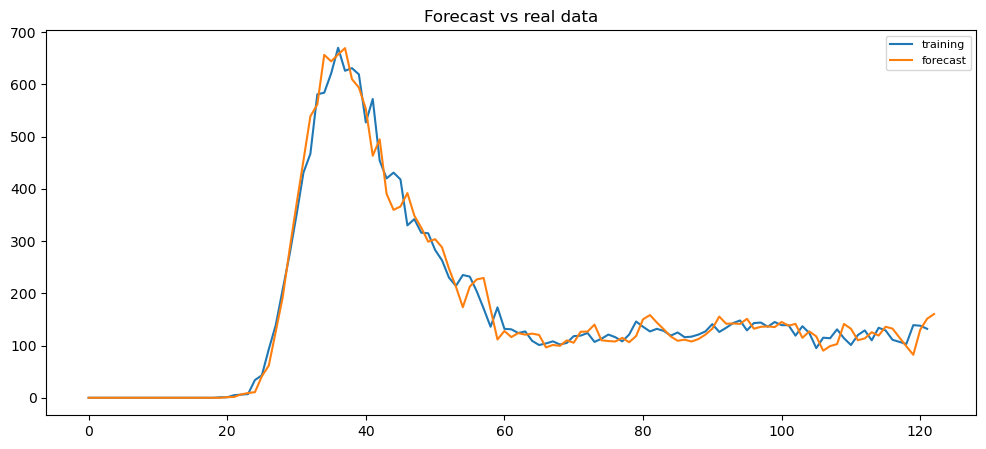

In [3]:
model = ARIMA(new_deaths, order=(4,4,4))  
fitted = model.fit()  
prediction=fitted.predict(start=0, end=len(new_deaths) , typ='levels')

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(new_deaths, label='training')
plt.plot(prediction, label='forecast')
plt.title('Forecast vs real data' )
plt.legend(loc='best', fontsize=8)
plt.show()

# set plot_verifs to True to plot the verifications
plot_verifs = False
if plot_verifs: 

    # on vérifir que les résidus sont bien du bruit blanc
    residuals = pd.DataFrame(fitted.resid)
    residuals.plot(title="Residuals")

    plt.show()
    residuals.plot(kind='kde', title='Density')
    plt.show()
    print(residuals.describe())
    # autocorrélation des résidus
    from pandas.plotting import autocorrelation_plot
    autocorrelation_plot(residuals)
    plt.show()



In [4]:

# set optimize_arima to True to optimize the ARIMA model
optimize_arima = False
if optimize_arima:
    min = 1000
    pmin=0
    dmin=0
    qmin=0
    for p in range(7): 
        print(p)
        for d in range(7): 
            for q in range(7): 
                if not (p,d,q) == (0,1,0):
                    model = ARIMA(new_deaths, order=(p,d,q))  
                    try : 
                        fitted = model.fit()  
                        prediction=fitted.predict(start=1, end=len(new_deaths) , typ='levels')
                        error = np.mean(np.abs(prediction - new_deaths))
                        if error < min:
                            min = error
                            pmin=p
                            dmin=d
                            qmin=q
                            print('new combinaition')
                            print(p,d,q,min)
                    except np.linalg.LinAlgError as err : 
                        print(p,d,q)
                        print('---------------------------')
                        print('ERROR')
                        print('---------------------------')


# results of precedent optimization: 
p_opt=1
d_opt=0
q_opt=0


This cell shows how to train an ARIMA on the interval $ [ 0;  s] $, with $s$ the split parameter, after which we make predictions. 

The reach parameter correspond to the range of the prediction (7 days for a week-ahead prediction)

[[554.4841706  568.81752452]
 [546.61964876 564.37766624]
 [500.15776367 535.55148605]
 [445.71434669 502.59831688]
 [426.60801725 503.41807653]
 [376.33521052 482.37824319]
 [341.11354517 475.72159929]]


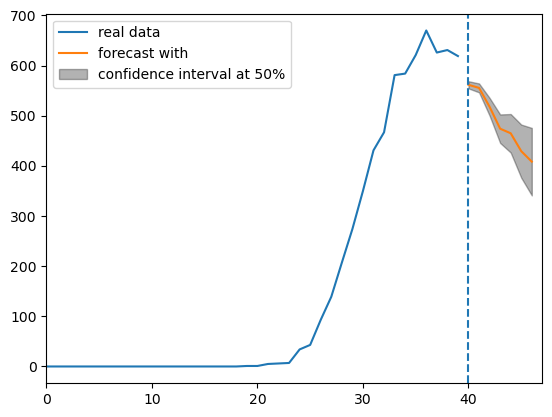

In [22]:
split=40
reach=7
al=0.5# (size of the prediction interval)
model = ARIMA(new_deaths[:split], order=(4,1,4))
fitted = model.fit()
predifore=fitted.get_forecast(reach).predicted_mean
predici=fitted.get_forecast(reach).conf_int(alpha=al)
print(predici)
# predici2=fitted.get_forecast(reach).conf_int(alpha=0.5)
# print(predici2)
ci_low=[elt[0] for elt in predici]
ci_high=[elt[1] for elt in predici]
plt.plot(new_deaths[:split], label='real data')
plt.plot([i for i in range(split, split + reach)] , predifore, label='forecast with')
plt.fill_between([i for i in range(split, split + reach)], ci_low, ci_high, color='black', alpha=.3, label='confidence interval at ' + str(round((1-al)*100)) + '%')
plt.legend()
plt.axvline(split, linestyle='--')
plt.xlim(0,split+reach)

plt.show()


In [21]:
class Model: 
    def __init__(self) :
        self.trained=False
    def train(self, train_dates, data):
        self.train_dates=train_dates
        self.data=data # to be implemented in the child class
    def predict(self, reach, alphas):
        pass # to be implemented in the child class 


class ARIMA_Modellocal(Model):

    def train(self, train_dates, data, grid_search=True): 
        self.data=data
        if grid_search:
            min = 1000
            pmin=0
            dmin=0
            qmin=0
            for p in range(7): 
                for d in range(4): 
                    for q in range(7): 
                        if not (p,d,q) == (0,1,0):
                            model = ARIMA(data, order=(p,d,q))  
                            try : 
                                fitted = model.fit()  
                                prediction=fitted.predict(start=1, end=len(data) , typ='levels')
                                error = np.mean(np.abs(prediction - data))
                                if error < min:
                                    min = error
                                    pmin=p
                                    dmin=d
                                    qmin=q
                            except np.linalg.LinAlgError as err : 
                                pass
        else :
            pmin=3
            dmin=0
            qmin=3
        self.model = ARIMA(data, order=(pmin,dmin,qmin))
        self.p=pmin
        self.d=dmin
        self.q=qmin
        self.fitted=self.model.fit()
        self.trained= True
        # self.data=data
    
    def predict(self, reach, alphas):
        assert self.trained, 'The model has not been trained yet'
        predifore=self.fitted.get_forecast(reach).predicted_mean
        confidence_intervals=[self.fitted.get_forecast(reach).conf_int(alpha=alp) for alp in alphas]
        return predifore, confidence_intervals
    
    def plot(self, reach, alpha): 
        assert self.trained, 'The model has not been trained yet'
        prediction, interval = self.predict(reach, [alpha])
        ci_low=[max(elt[0],0) for elt in interval[0]]
        ci_high=[elt[1] for elt in interval[0]]
        plt.plot([i for i in range(len(self.data))], self.data, label='real data')
        plt.plot([i for i in range(len(self.data), len(self.data) + reach)] , prediction, label='forecast ')
        plt.fill_between([i for i in range(len(self.data), len(self.data) + reach)], ci_low, ci_high, color='black', alpha=.3, label='confidence interval at ' + str(round((1-alpha)*100)) + '%')
        plt.legend()
        plt.axvline(len(self.data), linestyle='--')
        plt.xlim(0,len(self.data)+reach)
        plt.show()
        



c:\Users\grego\Miniconda3\envs\env_qcm\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


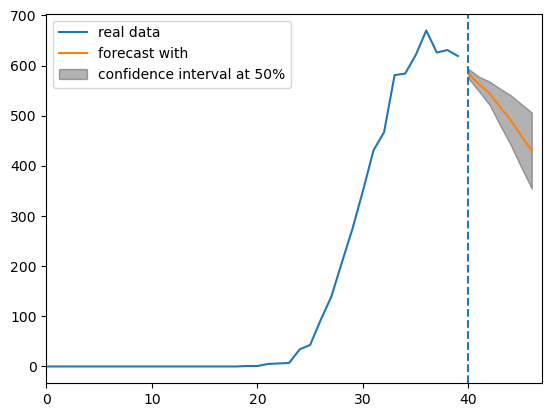

In [17]:
myarima=ARIMA_Modellocal()
myarima.train(dates_of_pandemic, new_deaths[:40], grid_search=False)
# myarima.predict(reach, [0.5])
myarima.plot( reach, 0.5)

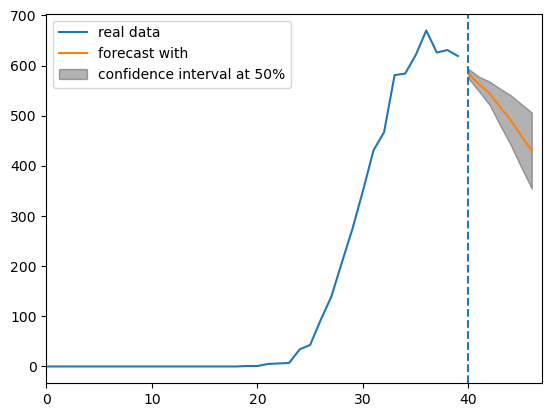

In [20]:
(myarima.plot( reach, 0.5))

**Other ways to get confidence intervals that we will not use**: 


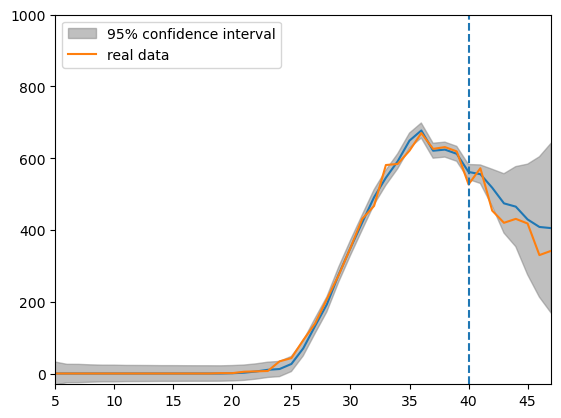

In [ ]:
split=40
model = ARIMA(new_deaths[:split], order=(4,1,4))
fitted = model.fit()
prediction=fitted.predict(start=1, end=len(new_deaths)-1) # line to get access to the predictions
ci=fitted.conf_int()
# plot the confidence interval
c_low=ci[:,0]
c_high=ci[:,1]

plot_predict(fitted, start=0, end=split+7)
plt.plot(new_deaths, label='real data')
# plt.plot(prediction[:split+7], label='forecast')
plt.xlim(5,split+7)
plt.ylim(-30, 1000)
plt.axvline(split, linestyle='--')
plt.legend()
plt.show()

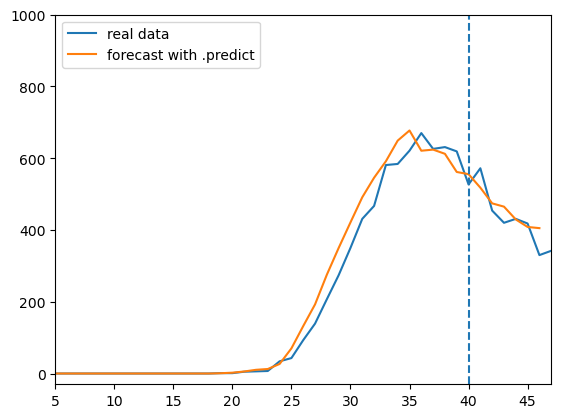

In [ ]:
split=40
model = ARIMA(new_deaths[:split], order=(4,1,4))
fitted = model.fit()
prediction=fitted.predict(start=1, end=len(new_deaths)-1) # line to get access to the predictions



plt.plot(new_deaths, label='real data')
plt.plot(prediction[:split+7], label='forecast with .predict')
plt.xlim(5,split+7)
plt.ylim(-30, 1000)
plt.axvline(split, linestyle='--')
plt.legend()
plt.show()

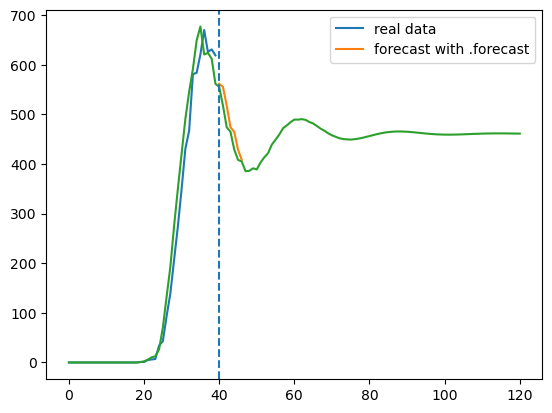

In [ ]:
%matplotlib inline
plt.plot(new_deaths[:split], label='real data')
forecast=fitted.forecast(7)
plt.plot([i for i in range(split, split + 7)] , forecast, label='forecast with .forecast')
plt.plot(prediction)
plt.legend()
plt.axvline(split, linestyle='--')
plt.show()